# 🧙‍♂️ Sample Generation with Pretrained Model + LLLA

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Jac-Zac/PML_DL_Final_Project/blob/master/notebooks/notebook_llla_flow.ipynb)

### Initial setup ⚙️

### If runned locally

In [1]:
%cd ..

/Users/jaczac/Github/PML_DL_Final_Project


In [1]:
!pip install laplace-torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.6/196.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

In [2]:
import os

repo_dir = "PML_DL_Final_Project"

if not os.path.exists(repo_dir):
    !git clone https://github.com/Jac-Zac/PML_DL_Final_Project.git
else:
    print(f"Repository '{repo_dir}' already exists. Skipping clone.")

Cloning into 'PML_DL_Final_Project'...
remote: Enumerating objects: 597, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 597 (delta 27), reused 33 (delta 19), pack-reused 542 (from 1)
Receiving objects: 100% (597/597), 1.23 MiB | 516.00 KiB/s, done.
Resolving deltas: 100% (351/351), done.


In [3]:
if os.path.isdir(repo_dir):
    %cd $repo_dir
    !pip install dotenv -q
else:
    print(f"Directory '{repo_dir}' not found. Please clone the repository first.")

Directory 'PML_DL_Final_Project' not found. Please clone the repository first.


### 📦 Imports

In [2]:
import torch

from src.models.flow import FlowMatching
from src.utils.data import get_dataloaders
from src.utils.plots import plot_image_grid, plot_image_uncertainty_grid
from src.utils.environment import get_device, set_seed, load_pretrained_model
import os

# Since on a notebook we can have nicer bars
import tqdm.notebook as tqdm

### 🧪 Setup: Seed and Device

In [3]:
seed = 1337
set_seed(seed)
device = get_device()
os.makedirs("checkpoints", exist_ok=True)

## 💡 Image Generation

#### 🛠️ Configuration Parameters

In [5]:
n_samples = 5
save_dir = "samples"
max_steps = 1000
model_name = "unet"
method = "flow"
ckpt_path = "checkpoints/best_model.pth"  # or use your last checkpoint

#### Define Class for QUDiffusion

In [6]:
class UQFlowMatching(FlowMatching):
    """
    Flow Matching with Uncertainty Quantification via Monte Carlo sampling.
    """

    def __init__(self, img_size: int = 64, device: torch.device = torch.device("cpu")):
        super().__init__(img_size, device)

    @torch.no_grad()
    def monte_carlo_velocity_covariance(
        self,
        model: nn.Module,
        x_mean: Tensor,
        x_var: Tensor,
        t: Tensor,
        S: int = 10,
        y: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Tensor]:
        """
        Monte Carlo estimation of Cov(x, v) where v is the velocity field.

        Args:
            model: velocity model outputting (mean, variance).
            x_mean: Mean state at time t.
            x_var: Variance of x at time t.
            t: Current time (shape: [B])
            S: Number of MC samples.
            y: Optional conditioning tensor.

        Returns:
            cov_est: Estimated Cov(x, v)
        """
        pass

    @torch.no_grad()
    def sample_with_uncertainty(
        self,
        model: nn.Module,
        steps: int = 100,
        y: Optional[Tensor] = None,
        x_init: Optional[Tensor] = None,
        log_intermediate: bool = False,
        t_sample_times: Optional[List[int]] = None,
        cov_num_sample: int = 10,
    ) -> Tuple[List[Tensor], List[Tensor]]:
        """
        Sample with uncertainty tracking and Cov(x, v) estimation.

        Returns:
            intermediates: List of sampled images at given steps.
            uncertainties: List of per-pixel variance maps at those steps.
        """
        model.eval()
        batch_size = (
            y.size(0)
            if y is not None
            else (x_init.size(0) if x_init is not None else 1)
        )
        channels = x_init.size(1) if x_init is not None else 1

        x_t = (
            x_init.to(self.device)
            if x_init is not None
            else torch.randn(
                batch_size, channels, self.img_size, self.img_size, device=self.device
            )
        )

        x_t_mean = x_t.clone()
        x_t_var = torch.zeros_like(x_t)
        cov_t = torch.zeros_like(x_t)

        dt = 1.0 / steps
        intermediates = []
        uncertainties = []

        for i in range(steps):
            t_scalar = i / steps
            t_tensor = torch.full((batch_size,), t_scalar, device=self.device)

            # Predict mean and variance of velocity
            v_mean, v_var = model(x_t, t_tensor, y=y)

            if log_intermediate and t_sample_times and i in t_sample_times:
                intermediates.append(self.transform_sampled_image(x_t.clone()))
                uncertainties.append(x_t_var.clone().cpu())

            # Update for next step
            # NOTE: TO REVIEW
            x_t = x_t_next
            x_t_mean = x_t
            x_t_var = x_t_var_next

        uncertainties = torch.stack(uncertainties) if uncertainties else []
        return intermediates, uncertainties

### 💪 Fit Laplace approximation

In [7]:
from src.models.llla_model import LaplaceApproxModel
from src.utils.data import get_llla_dataloader
from types import SimpleNamespace


num_classes = 10

# Load pretrained MAP model using best checkpoint
diff_model = load_pretrained_model(
    model_name="unet",
    ckpt_path="jac-zac/diffusion-project/best-model:v22",
    device=device,
    model_kwargs={"num_classes": num_classes, "time_emb_dim": 128},
    use_wandb=True,
)

# 2️⃣ Prepare data loaders for the Laplace fit
train_loader, _ = get_llla_dataloader(batch_size=128)

mnist_config = SimpleNamespace()
mnist_config.data = SimpleNamespace()
mnist_config.data.image_size = 28  # MNIST image size

# Wrap diffusion model with your Custom Model for Laplace last layer approx
# NOTE: Automatically call fit
laplace_model = LaplaceApproxModel(
    diff_model, train_loader, args=None, config=mnist_config
)

print("Laplace fitting completed on last layer of the diffusion model.")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /Users/jaczac/.config/netrc/netrc
wandb: Currently logged in as: jacopozac (jac-zac) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb:   1 of 1 files downloaded.  
                                                                                                                                                                                    

Laplace fitting completed on last layer of the diffusion model.


<!-- #region id="1d2b6a2d" -->
### 💨 Initialize Flow Process

<!-- #endregion -->

In [8]:
# Initialize uncertainty-aware diffusion (same interface as base class)
diffusion = UQFlowMatching(img_size=28, device=device)

In [9]:

import os

import matplotlib.pyplot as plt
import numpy as np
import torch


def plot_image_uncertainty_grid(
    model,
    method_instance,
    n: int,
    num_intermediate: int,
    max_steps: int,
    save_dir: str,
    device: torch.device,
    num_classes: int,
    cov_num_sample: int = 50,
    uq_cmp: str = "grey"
):
    """
    Generate and plot a grid of intermediate samples for either diffusion or flow.

    Args:
        model: The trained model.
        method_instance: The sampling method instance (Diffusion or FlowMatching).
        n (int): Number of classes from which to generate ([0,1,..,n-1]).
        num_intermediate (int): Number of intermediate steps to visualize.
        max_steps (int): Maximum number of steps or timesteps.
        save_dir (str): Directory to save the output image.
        device: Torch device.
        num_classes (int): Number of classes for label conditioning.
    """
    # Prepare conditioning labels
    y = torch.arange(n, device=device) % num_classes

    # Decide which type of timesteps to generate
    # if method_instance.__class__.__name__ == "FlowMatching":
    #     # Flow matching: choose indices between 0 and (steps-1)
    #     step_indices = torch.linspace(
    #         0, max_steps - 1, steps=num_intermediate, dtype=torch.int32
    #     ).tolist()

    #     all_samples_grouped = method_instance.sample(
    #         model,
    #         steps=max_steps,
    #         log_intermediate=True,
    #         t_sample_times=step_indices,
    #         y=y,
    #     )
    #     timesteps = step_indices
    # else:
        # Diffusion: choose timesteps between max_steps and 0
    t_sample_times = torch.linspace(
        max_steps-1,
        0,
        steps=num_intermediate,
        dtype=torch.int32,
    ).tolist()
    print("sample times", t_sample_times)

    all_samples_grouped, uncertainties = method_instance.sample_with_uncertainty(
        model,
        t_sample_times=t_sample_times,
        log_intermediate=True,
        y=y,
        cov_num_sample=cov_num_sample,
    )
    timesteps = t_sample_times

    ### ------------------ Plot images grid ------------------ ###

    # Stack all generated images into a (B, T, C, H, W) tensor
    stacked = torch.stack(all_samples_grouped)  # (T, B, C, H, W)
    permuted = stacked.permute(1, 0, 2, 3, 4)  # (B, T, C, H, W)
    num_samples, num_timesteps = permuted.shape[:2]   # extract B and T
    print("num timesteps", num_timesteps)

    # Save as a grid
    os.makedirs(save_dir, exist_ok=True)
    out_path_img = os.path.join(save_dir, "all_samples_grid.png")

    fig, axes = plt.subplots(
        num_samples, num_intermediate, figsize=(1.5 * num_intermediate, 1.5 * num_samples)
    )

    if num_samples == 1:
        axes = np.expand_dims(axes, 0)
    if num_intermediate == 1:
        axes = np.expand_dims(axes, 1)

    indices = np.linspace(0, num_timesteps - 1, num=num_intermediate, dtype=int)

    for row in range(num_samples):
        for idx, col in enumerate(indices):
            img = permuted[row, col].squeeze().cpu().numpy()
            ax = axes[row, col]
            ax.imshow(img, cmap="gray")
            ax.axis("off")
            if row == 0:
                ax.set_title(f"step={timesteps[col]}", fontsize=10)
            if col == 0:
                ax.set_ylabel(f"Sample {row+1}", fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path_img, bbox_inches="tight")
    plt.close()


    ### ------------------ Plot uncertainties grid ------------------ ###

    # Convert uncertainties to tensor if needed
    if isinstance(uncertainties, list):
        uncertainties = torch.stack(uncertainties)  # (T, B, C, H, W)

    # Multiplier
    mult = 700

    # Ensure uncertainties has same ordering: (B, T, C, H, W)
    uncertainties_permuted = uncertainties.permute(1, 0, 2, 3, 4) * mult

    out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")

    fig, axes = plt.subplots(
        num_samples, num_intermediate, figsize=(1.5 * num_intermediate, 1.5 * num_samples)
    )

    if num_samples == 1:
        axes = np.expand_dims(axes, 0)
    if num_intermediate == 1:
        axes = np.expand_dims(axes, 1)

    for row in range(num_samples):
        for col in range(num_intermediate):
            unc = uncertainties_permuted[row, col].squeeze().cpu().numpy()
            ax = axes[row, col]
            im = ax.imshow(unc, cmap=uq_cmp)  # Heatmap for uncertainty
            ax.axis("off")
            if row == 0:
                ax.set_title(f"step={timesteps[col]}", fontsize=10)
            if col == 0:
                ax.set_ylabel(f"Sample {row+1}", fontsize=10)

    plt.tight_layout()
    plt.savefig(out_path_unc, bbox_inches="tight")
    plt.close()

    return all_samples_grouped, uncertainties


sample times [999, 946, 893, 841, 788, 736, 683, 630, 578, 525, 473, 420, 368, 315, 262, 210, 157, 105, 52, 0]
num timesteps 20


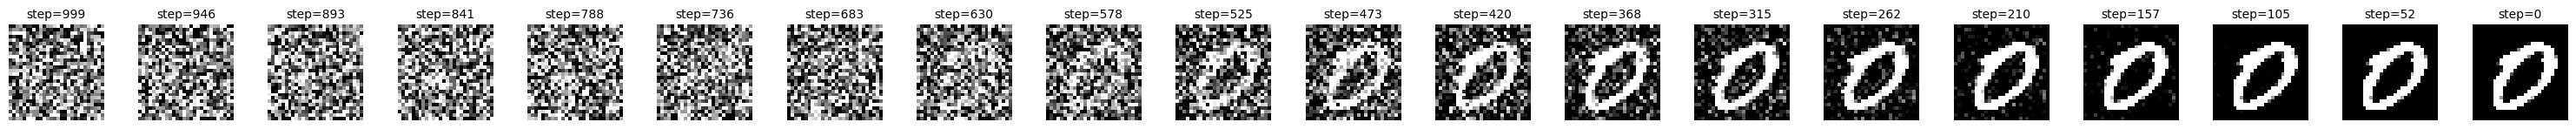

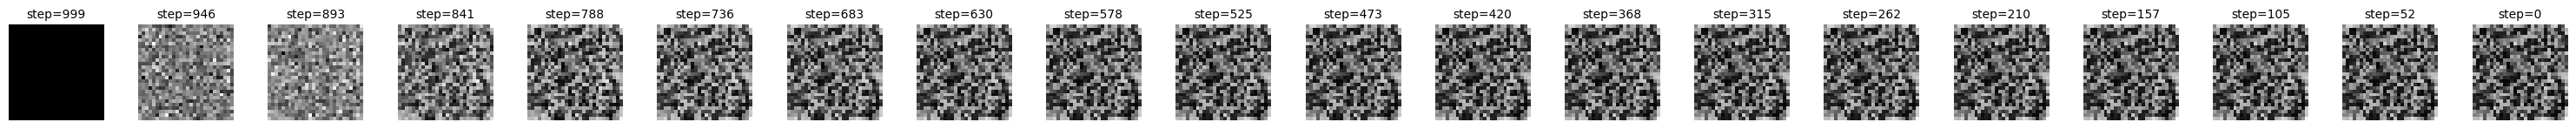

In [10]:
from PIL import Image

num_intermediate = 20

all_samples_grouped, uncertainties = plot_image_uncertainty_grid(
        laplace_model,
        diffusion,
        num_intermediate=num_intermediate,
        n=1,
        max_steps=max_steps,
        save_dir=save_dir,
        device=device,
        num_classes=num_classes,
        cov_num_sample=15,
    )


# Display samples grid
out_path_img = os.path.join(save_dir, "all_samples_grid.png")
display(Image.open(out_path_img))

# Display uncertainties grid
out_path_unc = os.path.join(save_dir, "all_uncertainties_grid.png")
display(Image.open(out_path_unc))


In [11]:
print(uncertainties.shape)

torch.Size([20, 1, 1, 28, 28])


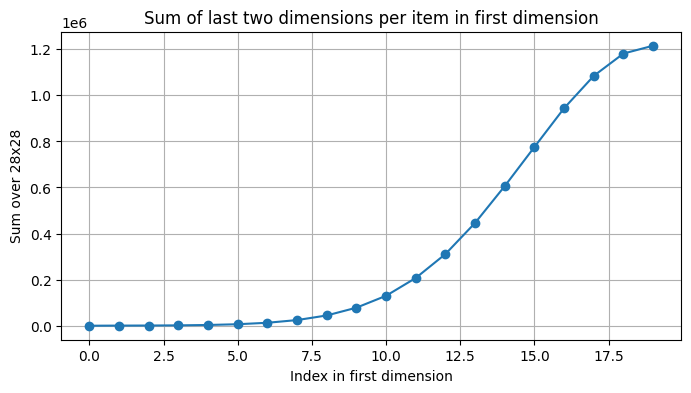

In [12]:
import torch
import matplotlib.pyplot as plt
# Sum over the last two dimensions (28x28)
sums = uncertainties.sum(dim=[-1, -2])  # shape: [10, 1, 1]

# Flatten to shape
sums_flat = sums.view(num_intermediate)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(range(num_intermediate), sums_flat.tolist(), marker='o', linestyle='-')
plt.title("Sum of last two dimensions per item in first dimension")
plt.xlabel("Index in first dimension")
plt.ylabel("Sum over 28x28")
plt.grid(True)
plt.show()